In [1]:
cd /content/drive/My Drive/

/content/drive/My Drive


In [2]:
import csv
import pandas as pd
import seaborn as sns
!pip install missingno
import missingno as msno

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1.	Analyze matched_sales.tsv

## 1.1 Explore the dataset and identify data issue

In [0]:
df2 = pd.read_csv('matched_sales.tsv', sep='\t')

In [4]:
df2.head(5)

,Timestamp,Environment,Os,Device,Campaign ID,User ID,Context ID,Transaction ID,Order Value
0,1569889040,web,Windows,Desktop,113450,2EEEE2185BB347E07653128DDD7946B4,6,687260E81F123BF7B22EB42E2CC740D9,32.08
1,1569890180,web,Android,Smartphone,137914,18F4B9C704A39843FE4354E1E2091942,8,4CA9C121F6F94CD135F4A6F4934D4843,149.92
2,1569890704,web,Windows,Desktop,137914,513CD8C04005C7ED66F34CD98C63C455,9,F44BB650A3149704B9F86EF8796E6604,125.10
3,1569892066,web,Android,Smartphone,137914,1620E50E507DDF33489D80D7423111DF,7,5E022540529ECBCB947C04D969260287,95.95
4,1569892673,web,Windows,Desktop,137914,85AC7958028EFF2231B4962D3611D2D3,6,8428EF0717350A6C843B91957A30464B,83.54


In [5]:
df2.columns

Index(['Timestamp', 'Environment', 'Os', 'Device', 'Campaign ID', 'User ID',
       'Context ID', 'Transaction ID', 'Order Value'],
      dtype='object')

Data visualization techniques to explore the dataset and identify data issues

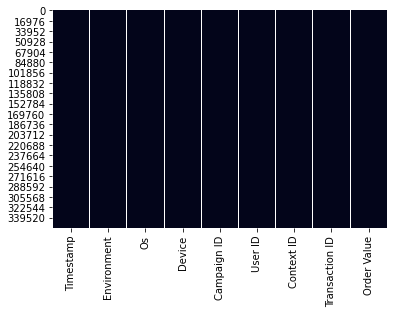

In [6]:
sns.heatmap(df2.isnull(), cbar=False)

Visualize the location of missing values.

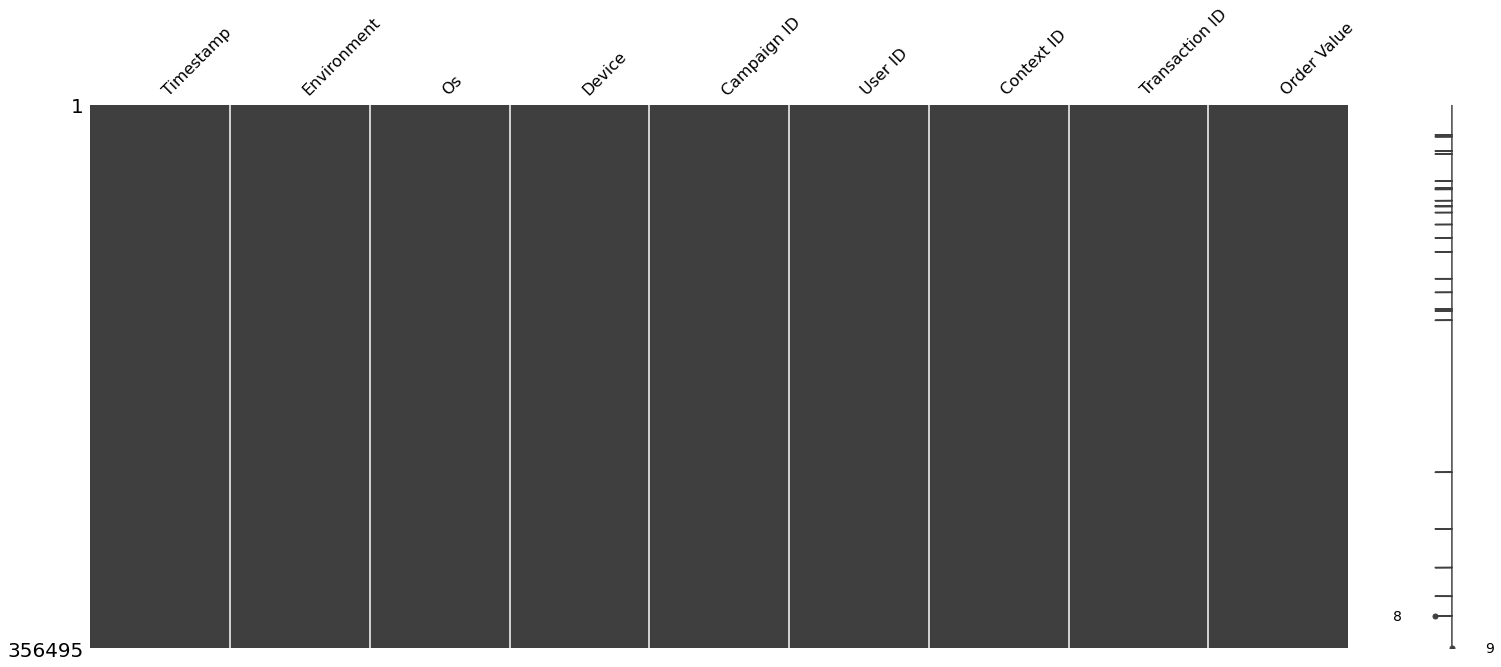

In [7]:
msno.matrix(df2)

Visualize the correlation matrix about the locations of missing values in columns.

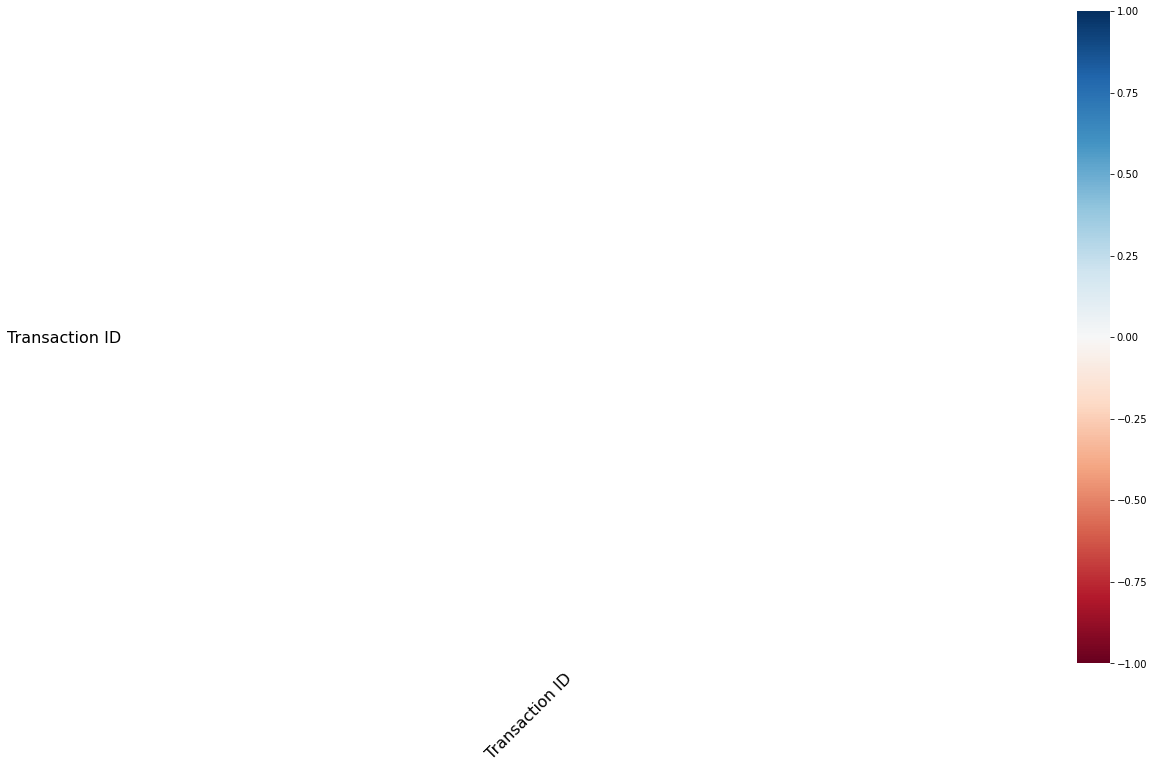

In [8]:
msno.heatmap(df2)

A simple visualization of nullity by column:

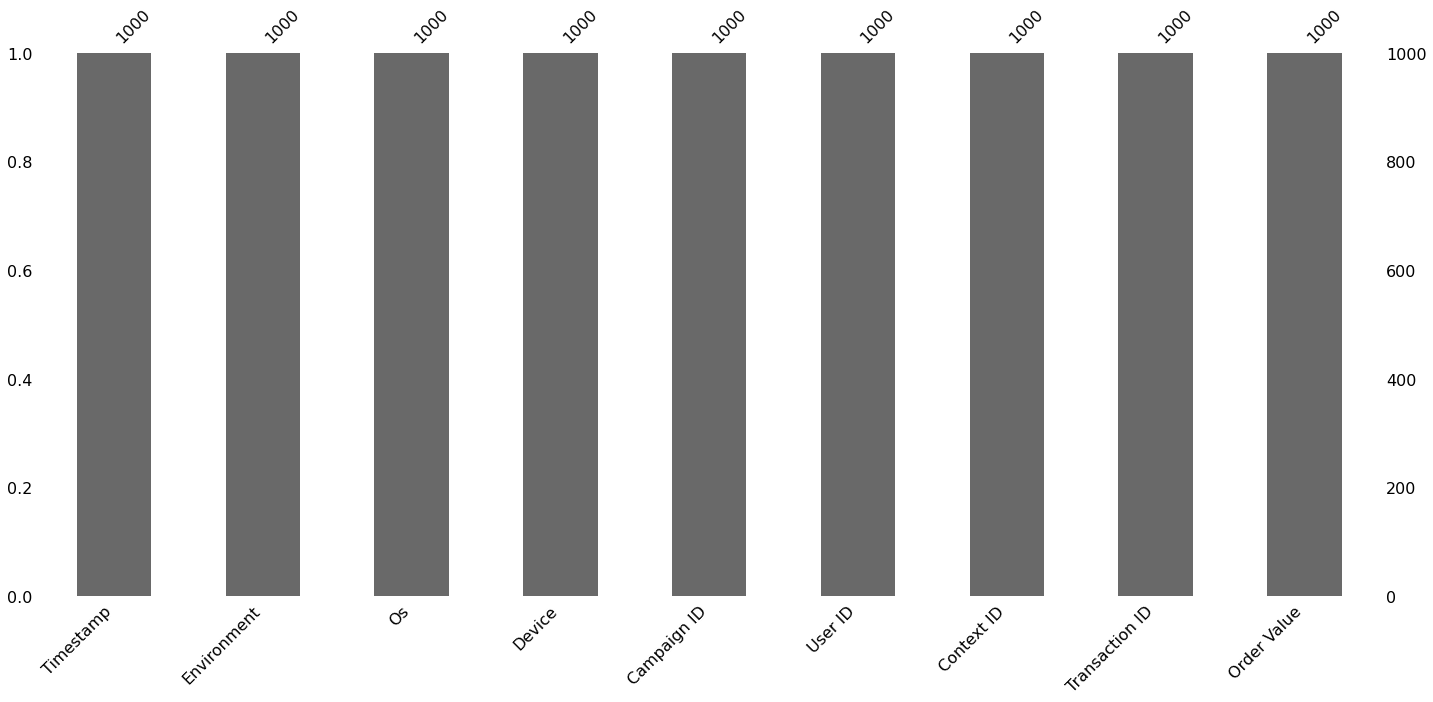

In [9]:
msno.bar(df2.sample(1000))

Fully correlate variable completion for revealing trends

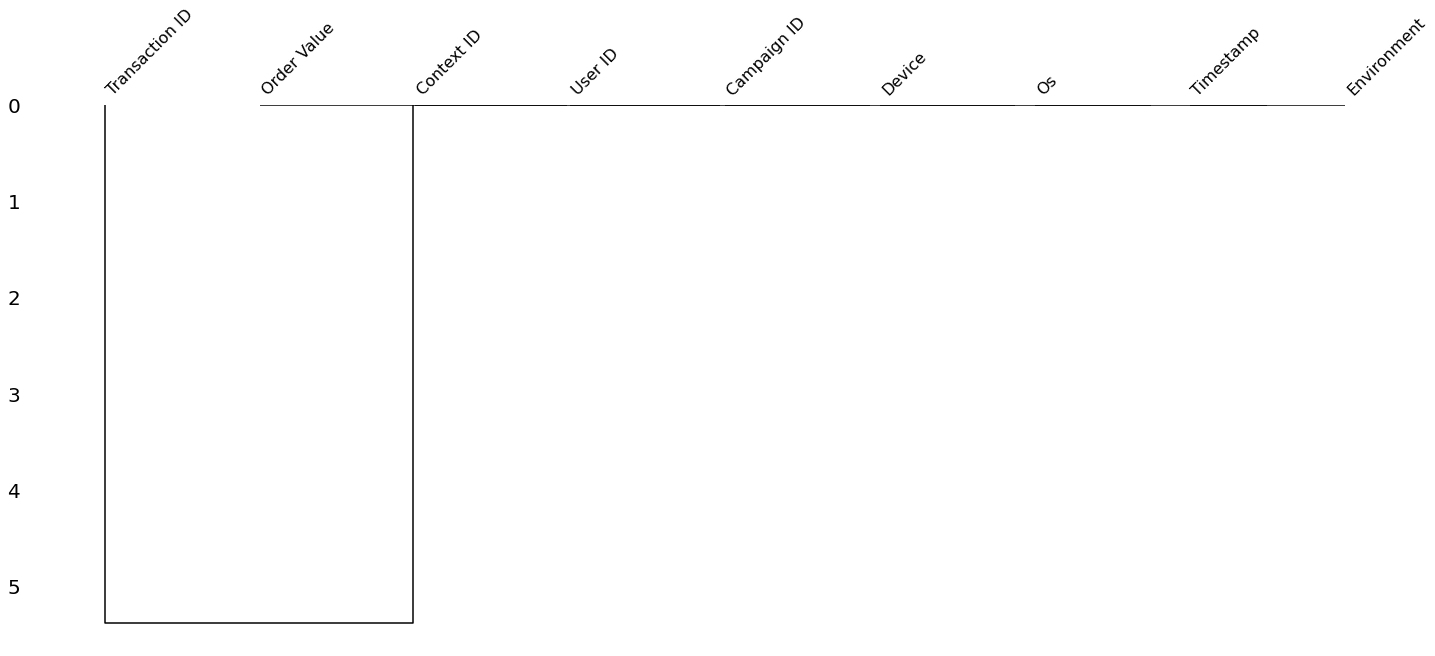

In [10]:
msno.dendrogram(df2)

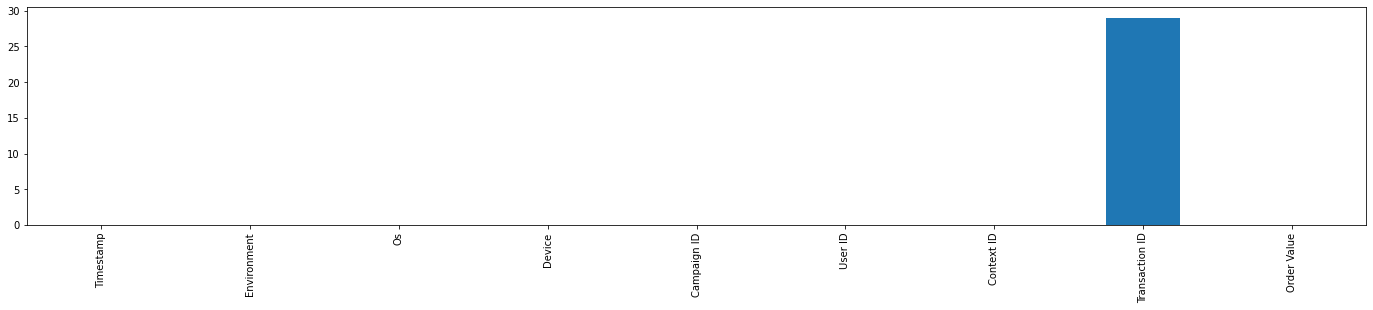

In [11]:
df2.isnull().sum().plot.bar(figsize=(24,4))

Remove Transactions with an Order Value of zero

In [0]:
diff1 = len(df2)

In [0]:
# Get null transactions of indexes for which column "Order Value" has value 0
indexTransactions = df2[ df2['Order Value'] == 0 ].index
 
# Delete these row indexes from dataFrame
df2.drop(indexTransactions , inplace=True)

In [14]:
difference = diff1 -len(df2) 
difference

1668

Remove Transactions with abnormally high Order Value 

In [15]:
x = df2['Order Value'].value_counts().sort_index() 
x

0.01        18
0.02        10
0.03         4
0.04         3
0.05         5
            ..
4733.71      1
5137.00      1
5141.04      1
5932.15      1
51658.00     1
Name: Order Value, Length: 39979, dtype: int64

In [0]:
diff1 = len(df2)

In [0]:
minima = min(x)
maxima = df2['Order Value'].max()
while x[maxima] == minima:
  # Get null transactions of indexes for which column "Order Value" has value abnormally high Order Value 
  indexTransactions = df2[ (df2['Order Value'] == df2['Order Value'].max())&(x[maxima] == minima)].index

  # Delete these row indexes from dataFrame
  df2.drop(indexTransactions , inplace=True)
  minima = min(x)
  maxima = df2['Order Value'].max()

In [18]:
difference = diff1 -len(df2) 
difference

52

Remove Duplicated Transactions

In [0]:
diff1= len(df2)

In [20]:
df2.drop_duplicates(subset = ["Transaction ID"]).head(5)

,Timestamp,Environment,Os,Device,Campaign ID,User ID,Context ID,Transaction ID,Order Value
0,1569889040,web,Windows,Desktop,113450,2EEEE2185BB347E07653128DDD7946B4,6,687260E81F123BF7B22EB42E2CC740D9,32.08
1,1569890180,web,Android,Smartphone,137914,18F4B9C704A39843FE4354E1E2091942,8,4CA9C121F6F94CD135F4A6F4934D4843,149.92
2,1569890704,web,Windows,Desktop,137914,513CD8C04005C7ED66F34CD98C63C455,9,F44BB650A3149704B9F86EF8796E6604,125.10
3,1569892066,web,Android,Smartphone,137914,1620E50E507DDF33489D80D7423111DF,7,5E022540529ECBCB947C04D969260287,95.95
4,1569892673,web,Windows,Desktop,137914,85AC7958028EFF2231B4962D3611D2D3,6,8428EF0717350A6C843B91957A30464B,83.54


In [21]:
difference = len(df2) - diff1
difference

0

## 1.2 Estimation of the client's time zone

In [22]:
df2['Date Time'] = pd.to_datetime(df2['Timestamp'], errors='coerce')
df2['Date Time'].value_counts
print(df2['Date Time'].min())
print(df2['Date Time'].max())

1970-01-01 00:00:01.569889040
1970-01-01 00:00:01.580428781


==> Unfortunately, the Data Time column has micro-second fluctuations. Hence, it's impossible to estimate the client's time zone 

## 1.3 Evolution of the Criteo attributed revenue over time

In [0]:
revenue = df2.set_index('Timestamp')
ts = revenue['Order Value'].cumsum()

In [24]:
ts.head(5)

Timestamp
1569889040     32.08
1569890180    182.00
1569890704    307.10
1569892066    403.05
1569892673    486.59
Name: Order Value, dtype: float64

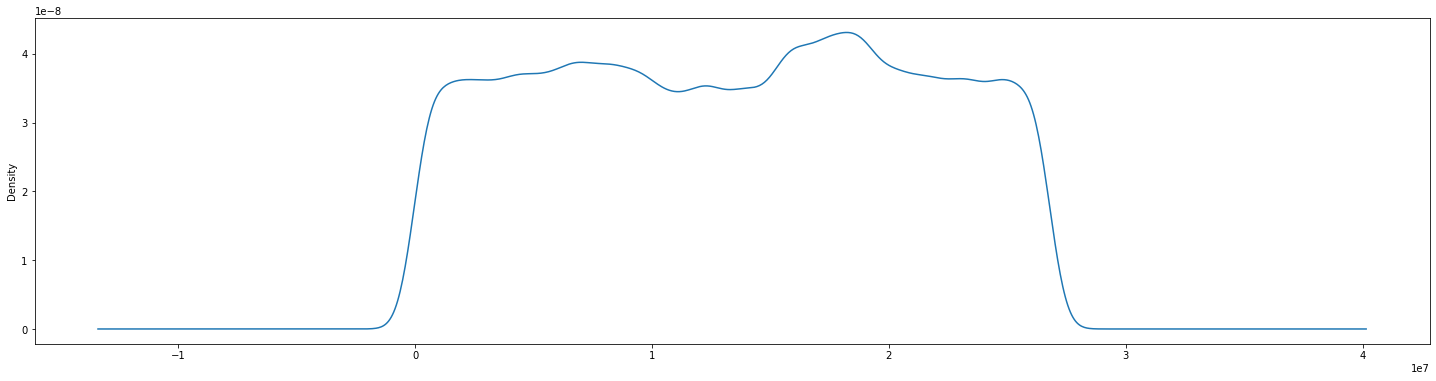

In [25]:
ts.plot.kde(figsize=(25,6))

==> The evolution of the Criteo attributed revenue over time follows a Gaussian distribution wich has a support nearly between -0,1$e^7$ and 2,7$e^7$

## 1.4 Evolution of the average OV per Os

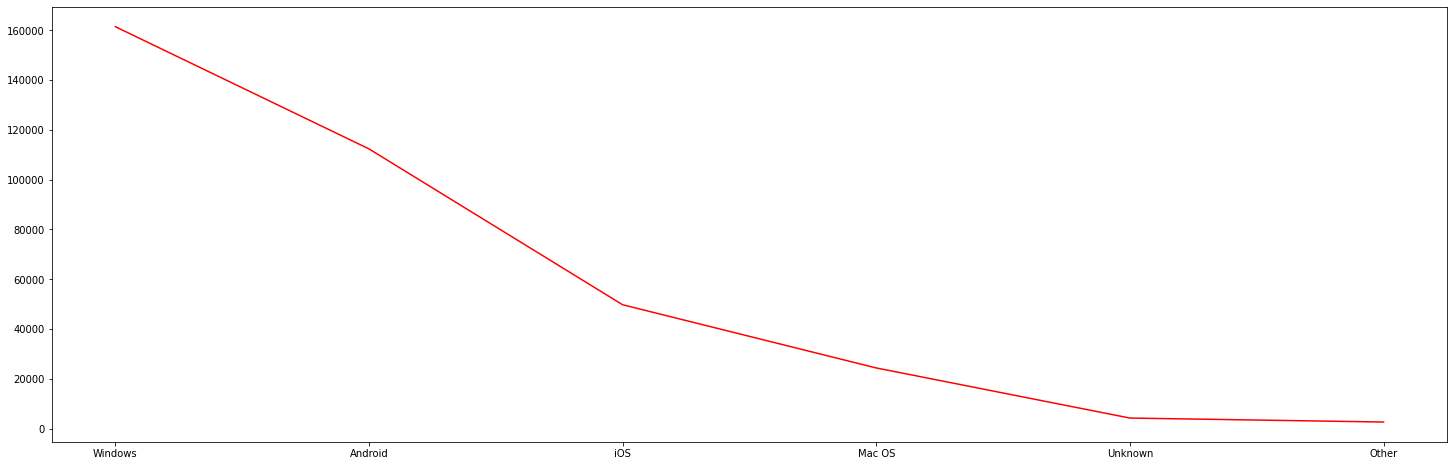

In [26]:
y = df2['Os'].value_counts()
y.plot(figsize=(25,8), c='r')

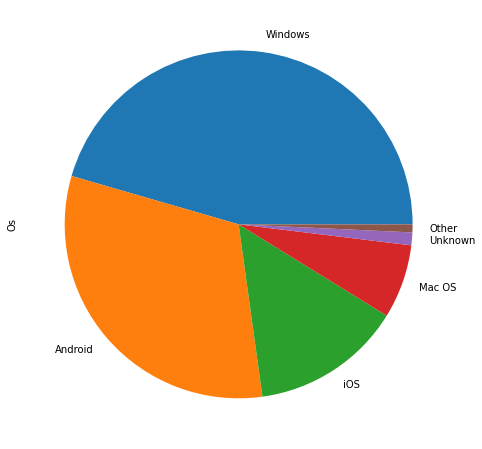

In [27]:
y.plot.pie(figsize=(25,8))

# 2.	Analyze campaigns_delivery.tsv

In [0]:
df1 = pd.read_csv('campaigns_delivery.tsv', sep='\t')
df2 = pd.read_csv('matched_sales.tsv', sep='\t')

In [29]:
df1.head(5)

,Day,Environment,Os,Campaign ID,Campaign Optimization,Campaign Type,Context IDs Eligible,Number of displays,Number of clicks,Criteo Revenue,Criteo Cost
0,2019-10-13,app,Android,194439,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",11487,199,1.223468,0.635936
1,2019-10-16,web,Windows,194439,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",0,0,0.000000,0.000000
2,2019-11-08,app,Android,194439,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",0,0,0.000000,0.000000
3,2019-10-11,web,Mac OS,194439,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",2102,21,1.392722,0.842206
4,2019-10-16,app,Android,194439,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",0,0,0.000000,0.000000


In [30]:
df1.columns

Index(['Day', 'Environment', 'Os', 'Campaign ID', 'Campaign Optimization',
       'Campaign Type', 'Context IDs Eligible', 'Number of displays',
       'Number of clicks', 'Criteo Revenue', 'Criteo Cost'],
      dtype='object')

## 2.1 Average Criteo Margin 

Average margin = (Revenue - Cost) / Nb

In [31]:
sum(df1['Criteo Revenue'] - df1['Criteo Cost']) / len(df1)

130.51849934385925

Plot the margin over time day 

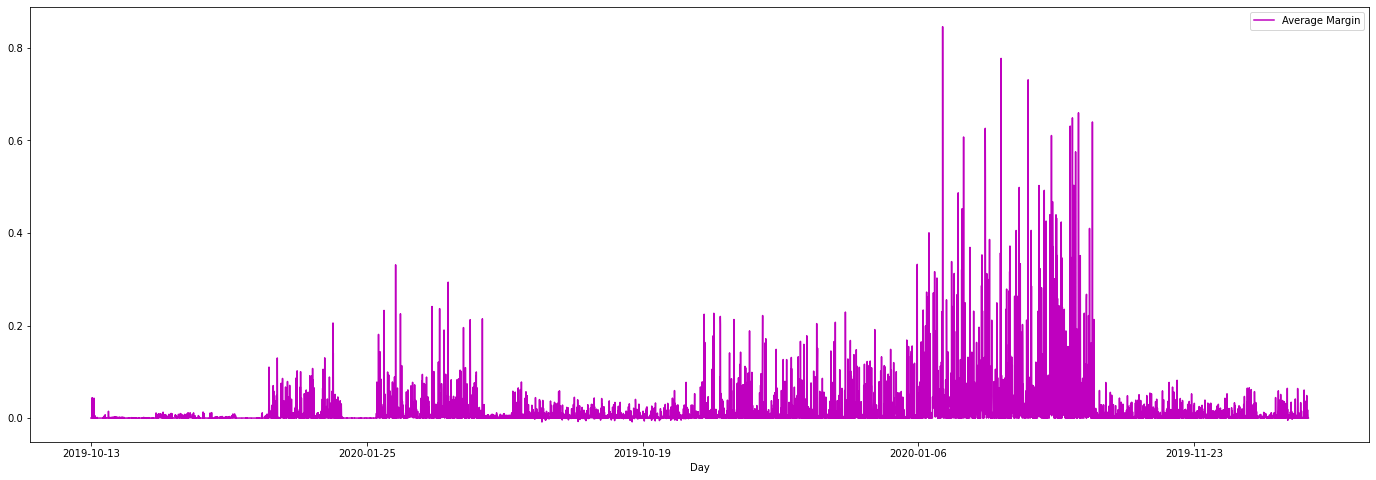

In [32]:
df1['Average Margin'] = (df1['Criteo Revenue'] - df1['Criteo Cost']) / len(df1)
cases = df1.set_index('Day')
cases.plot.line(y= 'Average Margin', figsize=(24,8),c='m')

Plot the margin over time Week

In [0]:
df1['Day'] = pd.to_datetime(df1['Day'], errors='coerce')
df1['Week Number'] = df1['Day'].dt.week

In [34]:
df1.sort_values('Week Number').head(5)

,Day,Environment,Os,Campaign ID,Campaign Optimization,Campaign Type,Context IDs Eligible,Number of displays,Number of clicks,Criteo Revenue,Criteo Cost,Average Margin,Week Number
5054,2019-12-31,web,iOS,196251,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",2024,70,1.367746,0.775313,6.710835e-05,1
3670,2020-01-04,other,Other,113890,Conversion Optimization,LOWER FUNNEL CUSTOM,"0-6,10",3,0,0.000000,0.001260,-1.427465e-07,1
1933,2020-01-03,app,Android,203946,Conversion Optimization,LOWER FUNNEL CUSTOM,0-10,2,0,0.000000,0.000299,-3.386951e-08,1
1100,2019-12-30,web,Windows,203945,Conversion Optimization,LOWER FUNNEL CUSTOM,0-10,1151,6,0.600000,0.613911,-1.575782e-06,1
3675,2020-01-03,other,Other,113890,Conversion Optimization,LOWER FUNNEL CUSTOM,"0-6,10",1,0,0.000000,0.000089,-1.012387e-08,1


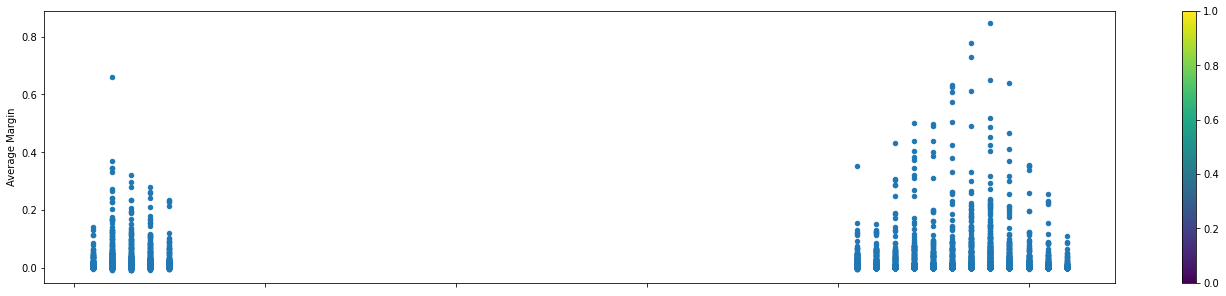

In [35]:
df1.plot.scatter(x='Week Number', y= 'Average Margin', cmap='coolwarm', figsize=(24,5))

In [0]:
cases2 = df1.set_index('Week Number')
cases2= cases2['Average Margin'].cumsum()

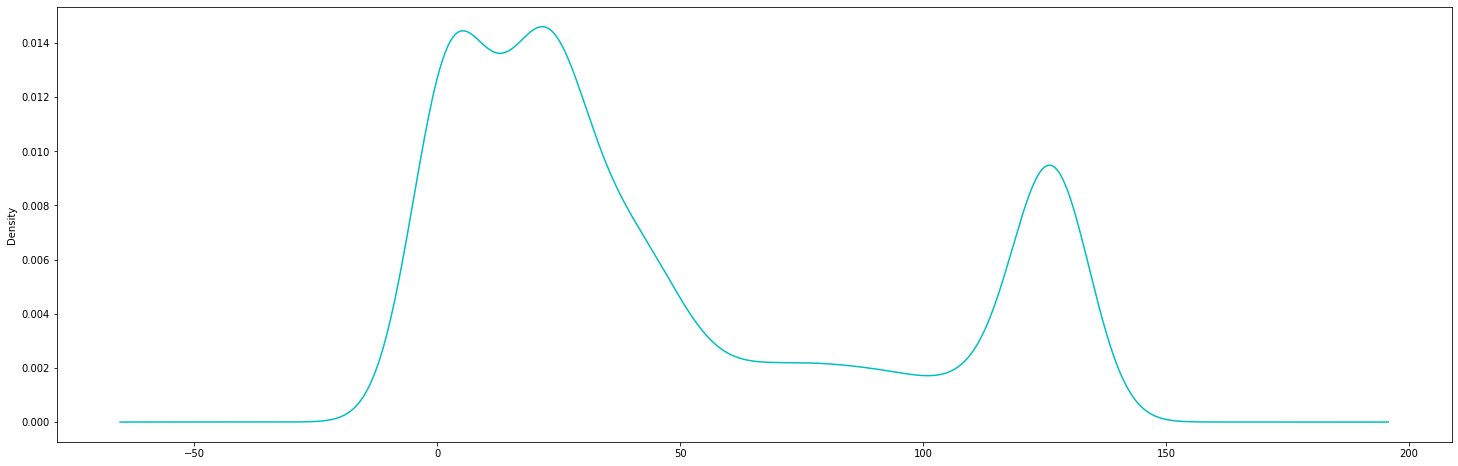

In [37]:
cases2.plot.kde(figsize=(25,8), c='c')

# 3. Join 2 Datasets

In [38]:
from datetime import datetime as dt
df1.drop_duplicates('Campaign ID').head(5).head(5)

,Day,Environment,Os,Campaign ID,Campaign Optimization,Campaign Type,Context IDs Eligible,Number of displays,Number of clicks,Criteo Revenue,Criteo Cost,Average Margin,Week Number
0,2019-10-13,app,Android,194439,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",11487,199,1.223468,0.635936,6.655316e-05,41
134,2019-10-16,web,Android,181696,Install Optimization,APP INSTALL,2-10,18546,295,19.527618,10.507066,1.021811e-03,42
247,2020-01-01,web,Unknown,203944,Conversion Optimization,MID FUNNEL CUSTOM,0-10,263,1,0.120000,0.052348,7.663368e-06,1
383,2019-12-29,app,Android,196137,Visit Optimization,INAPP,2-10,104919,529,35.733373,21.350788,1.629201e-03,52
592,2019-10-18,web,iOS,195553,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",33,0,0.014933,0.007327,8.615169e-07,42


In [39]:
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'], errors='coerce')
df2.drop_duplicates('Campaign ID').head(5)

,Timestamp,Environment,Os,Device,Campaign ID,User ID,Context ID,Transaction ID,Order Value
0,1970-01-01 00:00:01.569889040,web,Windows,Desktop,113450,2EEEE2185BB347E07653128DDD7946B4,6,687260E81F123BF7B22EB42E2CC740D9,32.08
1,1970-01-01 00:00:01.569890180,web,Android,Smartphone,137914,18F4B9C704A39843FE4354E1E2091942,8,4CA9C121F6F94CD135F4A6F4934D4843,149.92
16,1970-01-01 00:00:01.569899214,app,Unknown,Unknown,181696,F6D942C1460A843EC655E0E94852081D,0,782964676759C0929EC944C0B1FE3523,0.00
32,1970-01-01 00:00:01.569903195,web,Android,Smartphone,113890,27930057DDEA5C604A4B2709E38BA470,6,E03E0C66E15F9C68B2BCC6310EEE204E,23.60
46,1970-01-01 00:00:01.569904651,app,Unknown,Unknown,181694,0D18271FC787002DA8233FEC526C9751,4,9EBD6C234228BA58AA173B8559D705BE,0.00


In [0]:
join_df  =df1.merge(df2,how="inner",on=["Campaign ID","Environment","Os"])

In [41]:
join_df.head(5)

,Day,Environment,Os,Campaign ID,Campaign Optimization,Campaign Type,Context IDs Eligible,Number of displays,Number of clicks,Criteo Revenue,Criteo Cost,Average Margin,Week Number,Timestamp,Device,User ID,Context ID,Transaction ID,Order Value
0,2019-10-16,web,Windows,194439,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",0,0,0.0,0.0,0.0,42,1970-01-01 00:00:01.570719700,Desktop,024697246DC4A4A8749581992FEF11C9,6,B5BAB6DDE18FE610A4C6E7699E999BE7,6.58
1,2019-10-16,web,Windows,194439,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",0,0,0.0,0.0,0.0,42,1970-01-01 00:00:01.570724405,Desktop,10A863E71667D2F0970C3E1F324632D9,6,03AA2E596BABC34766D85F0F87A00211,36.02
2,2019-10-16,web,Windows,194439,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",0,0,0.0,0.0,0.0,42,1970-01-01 00:00:01.570728253,Desktop,065D1619341CB8043E6617F305425C58,6,B3ADBA07DD154798619D727835EE1BA2,43.74
3,2019-10-16,web,Windows,194439,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",0,0,0.0,0.0,0.0,42,1970-01-01 00:00:01.570728290,Desktop,38312AF12BF7C3ADDAC70358F1D5930F,5,42E758B5EE36A1D62DF15C68F811B0F4,177.42
4,2019-10-16,web,Windows,194439,Visit Optimization,MID FUNNEL CUSTOM,"0-6,10",0,0,0.0,0.0,0.0,42,1970-01-01 00:00:01.570732896,Desktop,C815E49C36BEEA2D04BBD039DB18792E,6,4B4B449EC2FB0CB00E4CC7EF2CFA97D6,40.41


# 4.	Analyze Criteo Campaigns Performance from the advertiser’s perspective

In [0]:
comp = join_df.groupby("Campaign ID")

In [0]:
compa = comp["Average Margin"]

Campaign ID
113450    AxesSubplot(0.125,0.125;0.775x0.755)
113890    AxesSubplot(0.125,0.125;0.775x0.755)
137914    AxesSubplot(0.125,0.125;0.775x0.755)
179971    AxesSubplot(0.125,0.125;0.775x0.755)
181694    AxesSubplot(0.125,0.125;0.775x0.755)
181696    AxesSubplot(0.125,0.125;0.775x0.755)
182459    AxesSubplot(0.125,0.125;0.775x0.755)
182460    AxesSubplot(0.125,0.125;0.775x0.755)
194439    AxesSubplot(0.125,0.125;0.775x0.755)
194905    AxesSubplot(0.125,0.125;0.775x0.755)
194906    AxesSubplot(0.125,0.125;0.775x0.755)
196137    AxesSubplot(0.125,0.125;0.775x0.755)
196140    AxesSubplot(0.125,0.125;0.775x0.755)
196251    AxesSubplot(0.125,0.125;0.775x0.755)
198525    AxesSubplot(0.125,0.125;0.775x0.755)
200094    AxesSubplot(0.125,0.125;0.775x0.755)
203944    AxesSubplot(0.125,0.125;0.775x0.755)
203945    AxesSubplot(0.125,0.125;0.775x0.755)
203946    AxesSubplot(0.125,0.125;0.775x0.755)
204638    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Average Margin, dtype: object

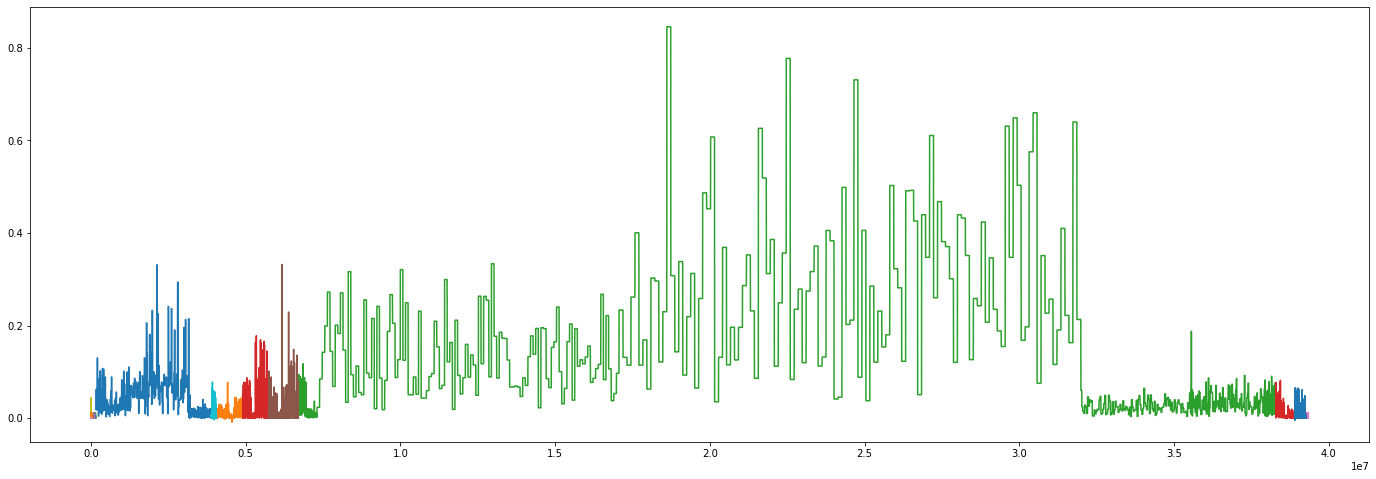

In [44]:
compa.plot(figsize=(24,8))

Which Criteo Campaign ID perform the best?

In [0]:
maximal = compa.max().max()

In [0]:
Transactions = join_df[ join_df["Average Margin"] == maximal ]

In [47]:
Transactions["Campaign ID"]

18607617    137914
18607618    137914
18607619    137914
18607620    137914
18607621    137914
             ...  
18736280    137914
18736281    137914
18736282    137914
18736283    137914
18736284    137914
Name: Campaign ID, Length: 128668, dtype: int64

==> Campaign ID = 137914

Which Criteo campaign types perform the best?

In [48]:
Transactions["Campaign Type"]

18607617    LOWER FUNNEL CUSTOM
18607618    LOWER FUNNEL CUSTOM
18607619    LOWER FUNNEL CUSTOM
18607620    LOWER FUNNEL CUSTOM
18607621    LOWER FUNNEL CUSTOM
                   ...         
18736280    LOWER FUNNEL CUSTOM
18736281    LOWER FUNNEL CUSTOM
18736282    LOWER FUNNEL CUSTOM
18736283    LOWER FUNNEL CUSTOM
18736284    LOWER FUNNEL CUSTOM
Name: Campaign Type, Length: 128668, dtype: object

==> Campaign Type = LOWER FUNNEL CUSTOM



## 4.3.	Is the COS/ROAS a relevant metric to look at for all Criteo campaign types ?

In [0]:
join_df["New Metric"] = join_df['Criteo Cost']/join_df['Criteo Revenue']

In [0]:
new = join_df.set_index("Campaign Type")


In [0]:
new_metric = new["New Metric"].cumsum()

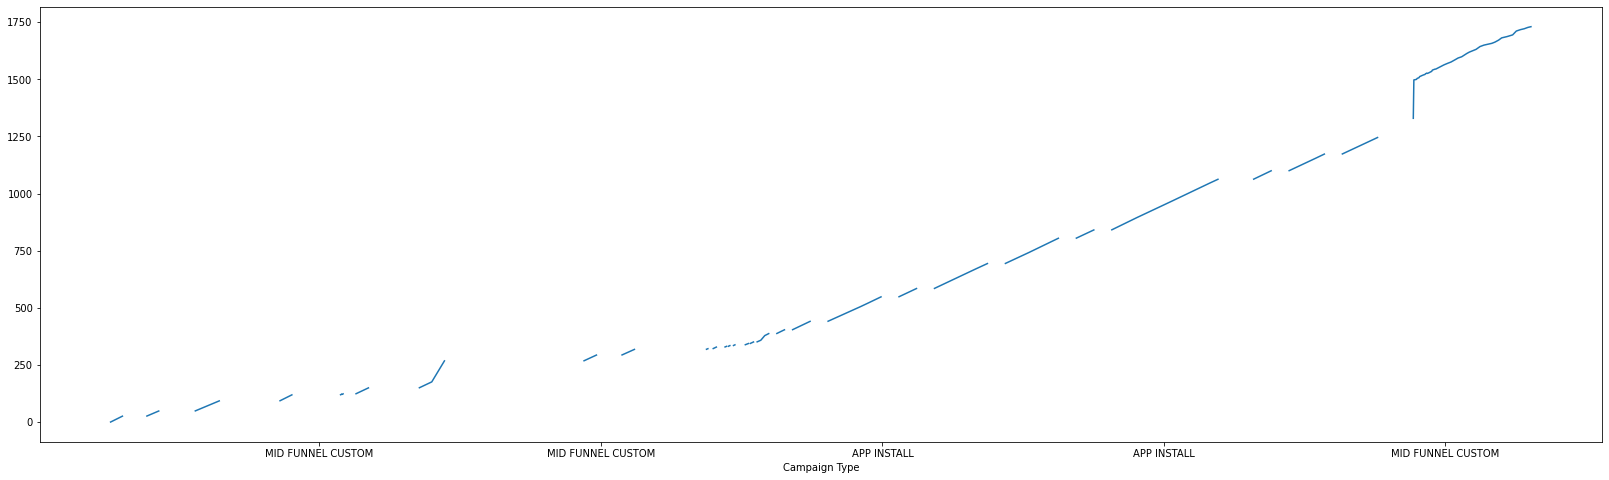

In [52]:
new_metric.plot(figsize=(28,8))

### Instead of calculating with COS/ROAS only, we can calculate (ROAS - COS) / (COS + ROAS) 